In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv, sys, time, os, re
import scipy.optimize
from math import *
π = np.pi

In [138]:
path = "results_diffus_7"

df = pd.read_csv(path+"/params.csv", sep=',', header=None)
df = df.set_index(0).T
params = {}
for key in df:
    params[key] = df[key][1]
params

{'N_gas': 400.0,
 'Delta_t': 3e-06,
 'd0': 0.03,
 'E0': 2.0,
 'cont_r': 0.48,
 'part_d': 0.06,
 'part_E0': 2.0,
 'part_m': 10.0,
 'target_T': 275.0,
 't_beg': 0.1,
 't_end': 0.3}

In [147]:
realizations = []
for file in os.listdir(path):
    itempath = path+"/"+file
    r0 = re.match('^([0-9]{3})$', file)
    if r0 is not None:
    
        df = pd.read_csv(itempath+"/p_traj.csv", sep=',')
        d = { 't' : np.array(df['t']), 'x' : np.array(df['px']), 'y' : np.array(df['py']) }
        df = pd.read_csv(itempath+"/res.csv", sep=',', header=None)
        df = df.set_index(0).T
        d['T'] = df['T'][1]
        d['T_std'] = df['T_std'][1]
        d['path'] = itempath
        realizations.append(d)
        
len(realizations)

347

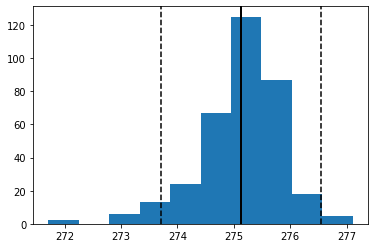

In [148]:
T = []
for rea in realizations:
    T.append( rea['T'] )
T = np.array(T)
T_mean = np.mean(T)
plt.hist(T)
plt.axvline(x = T_mean, color='black', lw=2)
T_window = 1.8*T_mean/350
plt.axvline(x = T_mean+T_window, linestyle='--', color='black')
plt.axvline(x = T_mean-T_window, linestyle='--', color='black')

On élimine toutes les trajectoires pour lesquelles $T$ dévie de plus de $T_\text{window}$ ($\simeq 1°$) de la moyenne. On vérifie que ça n'introduit pas de biais de sélection (la déviation de $T$ n'est pas une conséquence de la diffusion).

In [149]:
rea_sel = []
T_sel = []
T_std = []
for k in range(len(realizations)):
    if np.abs(T[k]-T_mean) < T_window:
        rea_sel.append(realizations[k])
        T_sel.append(T[k])
        T_std.append(realizations[k]['T_std'])
realizations = rea_sel
T_mean = np.mean(T_sel)
T_err = T_window + np.mean(T_std)
print("T = {:.2f} ± {:.2f} for {} realizations".format(T_mean,T_err,len(realizations)))

T = 275.21 ± 5.30 for 324 realizations


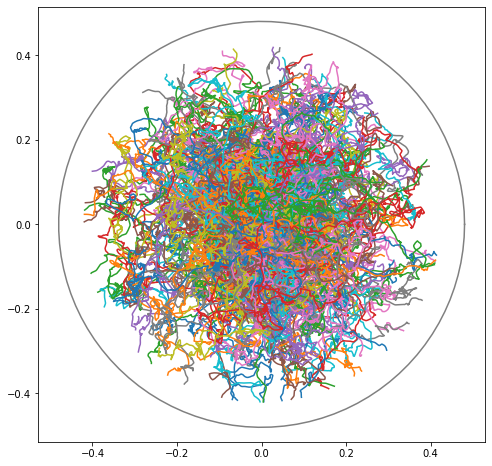

In [142]:
plt.figure(figsize=(8,8))
for rea in realizations:
    plt.plot(rea['x']-0.5, rea['y']-0.5)
u = np.linspace(0,2*np.pi,100)
plt.plot(params['cont_r']*np.cos(u), params['cont_r']*np.sin(u), color='grey')
plt.axis('equal')
plt.savefig(path+"/spaghettis.pdf")

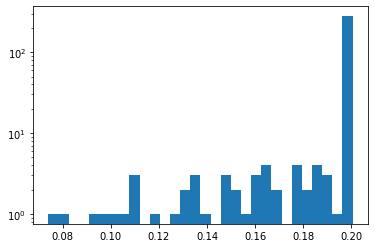

In [150]:
t_end = []
for rea in realizations:
    t = rea['t'][-1] - params['t_beg']
    t_end.append(t)
plt.hist(t_end, bins=30, log=True)
None

Pas mal de trajectoires qui se terminent tôt (la particule a touché le bord), et c'est embêtant si on veut exploiter toutes les données et pas seulement le début des trajectoires. Solution pas trop mauvaise : on extrapole/complète les trajectoires comme si la particule continuait à diffuser en $\sqrt{t}$ avec le coeff de diffusion aprroximatif mesuré. On vérifie a posteriori que le comportement est bien globalement diffusif, et de toute façon ça concerne un nombe minoritaire de trajectoires. On ne peut pas les éliminer car ça introduirait évidemment un biais de sélection.

In [144]:
for rea in realizations:
    rea['x0'] = None
    rea['y0'] = None

t = np.linspace(params['t_beg']+0.02, params['t_end'], 150)
samples_t_i = [30, 75, 120]
samples_acc_R2 = []
samples_acc_dir = []
R2 = np.zeros(150)
R2std = np.zeros(150)
for i in range(150):
    acc_R2 = []
    acc_dir = []
    record_sample = (i in samples_t_i)
    for rea in realizations:
        k = np.searchsorted(rea['t'], t[i], side='right')
        if rea['x0'] is None:
            rea['x0'] = rea['x'][k]
            rea['y0'] = rea['y'][k]
        if k >= len(rea['t']):
            k = -1
        r2 = (rea['x'][k]-rea['x0'])**2 + (rea['y'][k]-rea['y0'])**2
        if k == -1:
            r2 += D * (t[i] - rea['t'][-1])  # on simule une diffusion normale à partir de la fin de la traj
        acc_R2.append(r2)
        if record_sample:
            theta = atan2( rea['y'][k]-rea['y0'], rea['x'][k]-rea['x0'] )
            acc_dir.append(theta)
    if record_sample:
        samples_acc_R2.append(acc_R2)
        samples_acc_dir.append(acc_dir)
    R2[i] = np.mean(acc_R2)
    R2std[i] = np.std(acc_R2)
t -= t[0]

t0, t1 = 0.005, 25/T_mean
i0 = np.searchsorted(t, t0, side='left')
i1 = np.searchsorted(t, t1, side='right')-1
_coeff, _cov = scipy.optimize.curve_fit( (lambda t,D: D*t), t[i0:i1]-t[i0], R2[i0:i1] )
D = _coeff[0]
D_err = sqrt(np.diag(_cov)[0])
print("fit on {:.3f}->{:.3f} : D = {:.4f} ± {:.1f}%fit ± {:.1f}%stat".format(t[i0],t[i1],D,D_err/D*100,150/sqrt(len(realizations))))
D_err += D * 1.5/sqrt(len(realizations))

fit on 0.006->0.091 : D = 0.4341 ± 0.6%fit ± 8.3%stat


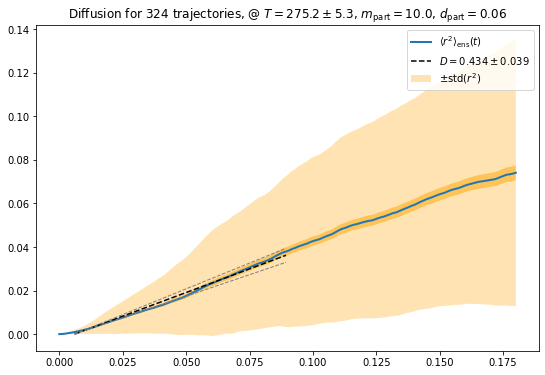

In [145]:
plt.figure(figsize=(9,6))
plt.fill_between(t, R2-R2std, R2+R2std, facecolor='orange', alpha=0.3, label=r"$\pm \operatorname{std}(r^2)$")
plt.fill_between(t, R2-R2std/np.sqrt(len(realizations)), R2+R2std/np.sqrt(len(realizations)), facecolor='orange', alpha=0.5)
plt.plot(t, R2, label=r"$\langle r^2 \rangle_\operatorname{ens}(t)$", lw=2)
plt.plot(t[i0:i1], D*(t[i0:i1]-t[i0]), '--', color='black', label=r"$D={:.3f}\pm{:.3f}$".format(D,D_err))
plt.plot(t[i0:i1], (D+D_err)*(t[i0:i1]-t[i0]), '--', color='grey', lw=1)
plt.plot(t[i0:i1], (D-D_err)*(t[i0:i1]-t[i0]), '--', color='grey', lw=1)
plt.legend()
plt.title("Diffusion for {} trajectories, @ $T={:.1f}\pm{:.1f}$, $m_\operatorname{{part}}={}$, $d_\operatorname{{part}}={}$".format(len(realizations), T_mean, T_err, params['part_m'], params['part_d']))
plt.savefig(path+"/diffus.pdf")

On ignore le début de la diffusion pour le fit de $D$, car le début est en régime inertiel ($\langle r^2 \rangle \propto t^2$) : on commence à `t[i0]`. On ignore la diffusion tardive car il commence à y avoir les effets de bords (diffusion plus lente vers la fin) et un nombre significatif de trajectoires déjà sorties extrapolées.

Pas simple de donner une incertitude sur $D$. On peut sous-sampler et voir les fluctuations de $D$. Disons maximum $4\%_\text{stat}$ pour 150 trajectoires, et $10\%_\text{stat}$ pour 25 trajectoires.

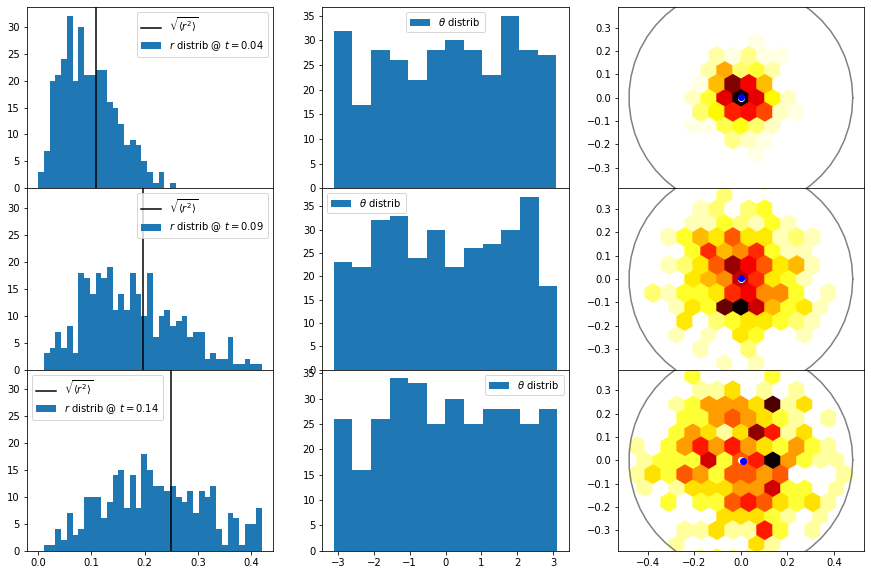

In [146]:
fig, axes = plt.subplots(nrows=len(samples_t_i), ncols=3, sharex='col', figsize=(15,10))
fig.subplots_adjust(hspace=0)
for j in range(len(samples_t_i)):
    axes[j][0].hist(np.sqrt(samples_acc_R2[j]), bins=np.linspace(0,params['cont_r']-params['part_d'],40), label=r"$r$ distrib @ $t={:.2f}$".format(t[samples_t_i[j]]))
    axes[j][0].axvline(x=sqrt(R2[samples_t_i[j]]), label=r"$\sqrt{\langle r^2\rangle}$", color='black')
    if j != 0:
        axes[j][0].set_ylim(axes[0][0].get_ylim())
    axes[j][0].legend()
    axes[j][1].hist(samples_acc_dir[j], bins=12, label=r"$\theta$ distrib")
    axes[j][1].legend()
    acc_x = np.sqrt(samples_acc_R2[j]) * np.cos(samples_acc_dir[j])
    acc_y = np.sqrt(samples_acc_R2[j]) * np.sin(samples_acc_dir[j])
    center_x = np.mean(acc_x)
    center_y = np.mean(acc_y)
    axes[j][2].hexbin(acc_x, acc_y, gridsize=14, extent=(-params['cont_r'],params['cont_r'],-params['cont_r'],params['cont_r']), cmap='hot_r')
    u = np.linspace(0,2*np.pi,50)
    axes[j][2].plot(params['cont_r']*np.cos(u), params['cont_r']*np.sin(u), color='grey')
    axes[j][2].scatter([0],[0], color='white', label="center")
    axes[j][2].scatter([center_x],[center_y], color='blue', label="distrib center")
    axes[j][2].axis('equal')
plt.savefig(path+"/distribs_r_theta.pdf")

In [45]:
rea_sel = []
for k in range(len(realizations)):
    if k%3 != 0:
        rea_sel.append(realizations[k])
realizations = rea_sel

In [8]:
D = 0.3

In [173]:
cfff_tau, cfff_xx_mean, cfff_xy_mean, cfff_yy_mean = None, None, None, None
cfxfx_tau, cfxfx_mean = None, None
cvxvx_Δtau, cvxvx_mean = None, None

for rea in realizations:
    
    df = pd.read_csv(rea['path']+"/c_f_f_fine.csv", sep=',')
    if cfff_tau is None:
        cfff_tau = np.array(df['tau'])
        cfff_xx_mean = np.zeros(len(cfff_tau))
        cfff_xy_mean = np.zeros(len(cfff_tau))
        cfff_yy_mean = np.zeros(len(cfff_tau))
    cfff_xx_mean += np.array(df['c_fx_fx'])
    cfff_xy_mean += np.array(df['c_fx_fy'])
    cfff_yy_mean += np.array(df['c_fy_fy'])
    
    df = pd.read_csv(rea['path']+"/c_fx_fx.csv", sep=',')
    if cfxfx_tau is None:
        cfxfx_tau = np.array(df['tau'])
        cfxfx_mean = np.zeros(len(cfxfx_tau))
    cfxfx_mean += np.array(df['c_fx_fx'])
    
    df = pd.read_csv(rea['path']+"/c_vx_vx.csv", sep=',')
    i0 = np.searchsorted(df['tau'], 0, side='left')
    if cvxvx_Δtau is None:
        cvxvx_Δtau = np.diff(df['tau'])[i0]
        cvxvx_mean = np.zeros(len(df['tau'])-i0)
    c_vx_vx = np.array(df['c_vx_vx'])[i0:]
    if len(c_vx_vx) < len(cvxvx_mean):
        cvxvx_mean = cvxvx_mean[0:len(c_vx_vx)]
    if len(c_vx_vx) > len(cvxvx_mean):
        c_vx_vx = c_vx_vx[0:len(cvxvx_mean)]  
    cvxvx_mean += c_vx_vx

cfff_xx_mean /= len(realizations)
cfff_xy_mean /= len(realizations)
cfff_yy_mean /= len(realizations)
cfxfx_mean /= len(realizations)
cvxvx_mean /= len(realizations)

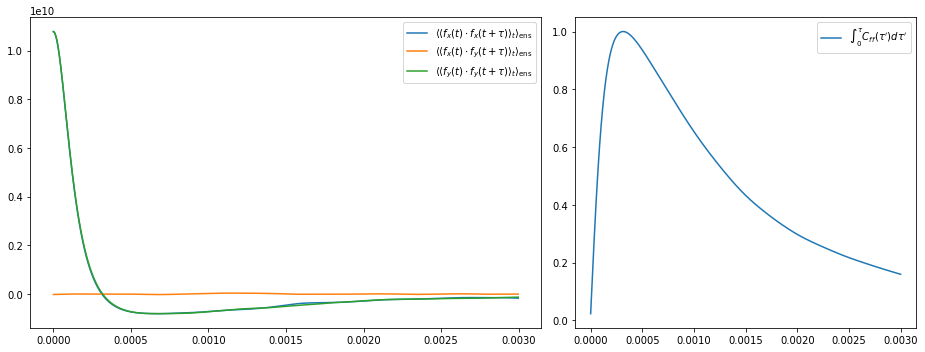

In [237]:
fig, (ax0, ax1) = plt.subplots(1,2, gridspec_kw={'width_ratios':[3,2]}, figsize=(13,5))
ax0.plot(cfff_tau, cfff_xx_mean, label=r"$\langle\langle f_x(t) \cdot f_x(t+\tau) \rangle_t\rangle_\operatorname{ens}$")
ax0.plot(cfff_tau, cfff_xy_mean, label=r"$\langle\langle f_x(t) \cdot f_y(t+\tau) \rangle_t\rangle_\operatorname{ens}$")
ax0.plot(cfff_tau, cfff_yy_mean, label=r"$\langle\langle f_y(t) \cdot f_y(t+\tau) \rangle_t\rangle_\operatorname{ens}$")
ax0.legend()
cfff_int = np.cumsum(cfff_xx_mean+cfff_yy_mean)
cfff_int /= np.max(cfff_int)
ax1.plot(cfff_tau, cfff_int, label=r"$\int_0^\tau C_{ff}(\tau') d\tau'$")
ax1.legend()
fig.tight_layout()

Queue qui semble être en $\tau^{-2}$. L'intégrale semble tendre vers $0$, et pas plateau.

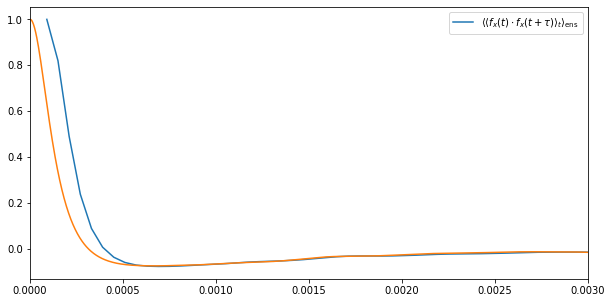

In [253]:
plt.figure(figsize=(10,5))
i0 = np.searchsorted(cfxfx_tau, 0, side='left')
plt.plot(cfxfx_tau[i0+1:], cfxfx_mean[i0:-1]/cfxfx_mean[i0], label=r"$\langle\langle f_x(t) \cdot f_x(t+\tau) \rangle_t\rangle_\operatorname{ens}$")
plt.legend()
plt.xlim((0,0.003))
plt.plot(cfff_tau, cfff_xx_mean/cfff_xx_mean[0])

In [254]:
cfxfx_tau[i0]

3.0008e-05

(0.0, 0.005)

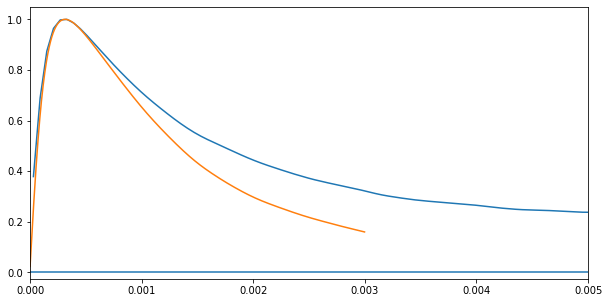

In [245]:
plt.figure(figsize=(10,5))
cff_int = np.cumsum(cfxfx_mean[i0:])
cff_int /= np.max(cff_int)
plt.plot(cfxfx_tau[i0:], cff_int)
plt.plot(cfff_tau, cfff_int)
plt.axhline(y=0)
plt.xlim((0,0.005))

(0.0, 0.003)

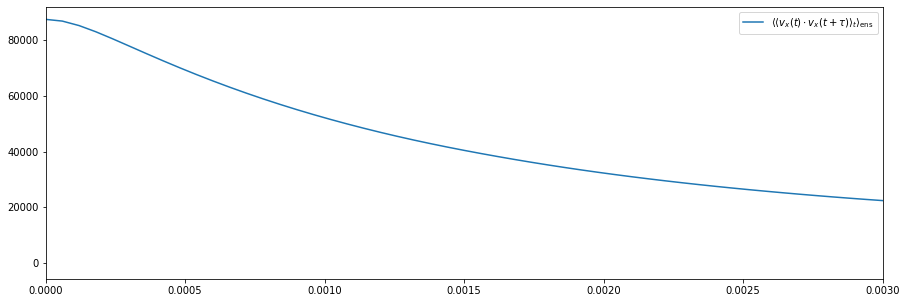

In [223]:
plt.figure(figsize=(15,5))
plt.plot(cvxvx_Δtau*np.arange(0,len(cvxvx_mean)), cvxvx_mean, label=r"$\langle\langle v_x(t) \cdot v_x(t+\tau) \rangle_t\rangle_\operatorname{ens}$")
plt.legend()
plt.xlim((0,0.003))

---

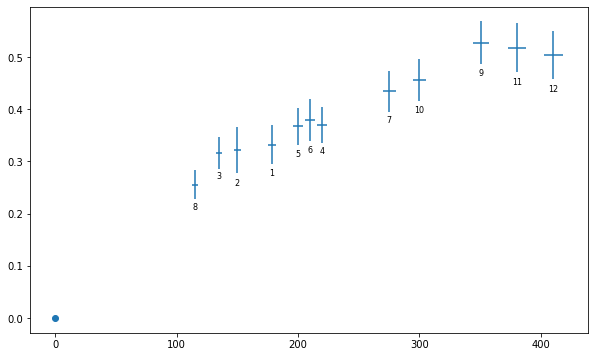

In [49]:
# avec t1 = 25/T_mean
#      T_window = 1.8*T_mean/350
plt.figure(figsize=(10,6))
res_label = [  "1",   "2",   "3",   "4",   "5",   "6",   "7",   "8",   "9",  "10",  "11",  "12"]
res_T =     [178.6, 150.0, 134.9, 219.9, 199.9, 209.9, 275.2, 114.9, 350.7, 300.0, 380.3, 410.4]
res_T_err = [  3.5,   3.2,   2.7,   4.3,   3.9,   4.1,   5.3,   2.3,   6.7,   5.7,   7.2,   7.7]
res_D =     [0.332, 0.321, 0.316, 0.370, 0.367, 0.379, 0.434, 0.255, 0.527, 0.456, 0.518, 0.503]
res_D_err = [0.038, 0.044, 0.030, 0.034, 0.036, 0.040, 0.039, 0.028, 0.041, 0.041, 0.047, 0.046]
plt.errorbar(res_T, res_D, xerr=res_T_err, yerr=res_D_err, linestyle=' ')
plt.scatter([0],[0])
for i in range(len(res_T)):
    plt.annotate(res_label[i], (res_T[i],res_D[i]-1.2*res_D_err[i]), size=8, ha='center', va='top')

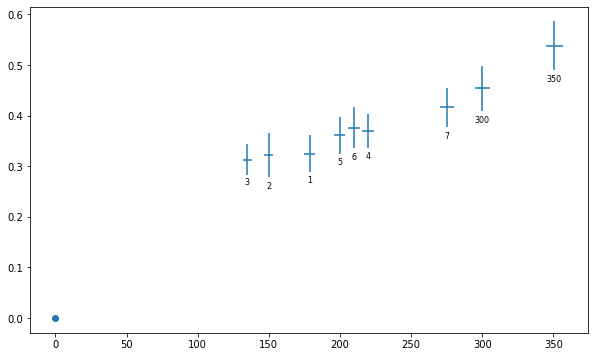

In [40]:
# avec t1 = 22/T_mean
#      T_window = 1
plt.figure(figsize=(10,6))
res_label = [  "1",   "2",   "3",   "4",   "5",   "6",   "7", "300", "350"]
res_T =     [178.6, 150.0, 134.9, 219.9, 199.9, 209.8, 275.2, 300.1, 350.7]
res_T_err = [  3.6,   3.0,   3.0,   4.2,   3.9,   4.0,   4.9,   5.2,   5.9]
res_D =     [0.325, 0.322, 0.313, 0.370, 0.361, 0.376, 0.416, 0.454, 0.531]
res_D_err = [0.036, 0.044, 0.030, 0.034, 0.036, 0.040, 0.039, 0.044, 0.053]
plt.errorbar(res_T, res_D, xerr=res_T_err, yerr=res_D_err, linestyle=' ')
plt.scatter([0],[0])
for i in range(len(res_T)):
    plt.annotate(res_label[i], (res_T[i],res_D[i]-1.2*res_D_err[i]), size=8, ha='center', va='top')

In [52]:
part_d = 6e-2
cont_r_0 = 0.48
N_0 = 400
dens = N_0 / (π*cont_r_0**2 - π*part_d**2)

N_new = 800
cont_r_new = np.sqrt(( N_new / dens + π*part_d**2 )/π)
cont_r_new

0.6761656601750786